# Tutorial
## Human Parsing On Binary Images

## STEP1: Setup

In [ ]:
!git clone https://github.com/GoGoDuck912/Self-Correction-Human-Parsing.git
%cd Self-Correction-Human-Parsing
!pip install -r requirements.txt

## STEP2: Import Libraries

In [3]:
import os
import glob
import pickle
import cv2
import numpy as np
from PIL import Image,ImageEnhance
import matplotlib.pyplot as plt

## STEP3: Download Dataset

In [ ]:
!python data_extractor.py

## STEP4: Download Weights

In [ ]:
!python get_weights.py

## STEP5: Load Images

In [10]:
for index,path in enumerate(os.listdir("./Download")):
    path = glob.glob(os.path.join(f"./Download/{path}/*"))
    for file in path:
        with open(file,"rb") as f:
            data = pickle.load(f,encoding="latin")
            for image in range(len(data["RGB"])):
                img = np.array(data["RGB"][image])
                img = Image.fromarray(img[...,::-1])
                enhancer = ImageEnhance.Brightness(img)
                img = enhancer.enhance(1.5) #  Increase brightness
                os.makedirs("extracted_data",exist_ok=True)
                img.save(f"extracted_data/image_{index}_{image}.jpg")

## STEP6: Convert RGB Images To Segmentation Images

In [ ]:
os.makedirs("segmentation_images")
!python simple_extractor.py --dataset "pascal" --model-restore "./weights/pascal.pth" --input-dir "./extracted_data" --output-dir "./segmentation_images"

## STEP7: Create Dataset

In [ ]:
# Create Folder Dataset
os.makedirs("Dataset",exist_ok=True)
os.makedirs("Dataset/train_images",exist_ok=True)
os.makedirs("Dataset/val_images",exist_ok=True)
os.makedirs("Dataset/train_segmentations",exist_ok=True)
os.makedirs("Dataset/val_segmentations",exist_ok=True)

train_id = open("Dataset/train_id.txt", "w")
        val_id = open("Dataset/val_id.txt", "w")
        for index, img in enumerate("./segmentation_images"):
            img = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
            img[img!=0] = 255
            if index <800:
                cv2.imwrite(f"Dataset/train_images/img{index}.jpg",img) # training binary person images with jpg format
            else:
                cv2.imwrite(f"Dataset/val_images/img{index}.jpg",img) # validation binary person images with jpg format
        for index, img in enumerate("./segmentation_images"):
            img = cv2.imread(img)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            # labels
            img[img==0]=0  # background
            img[img==38]=1  # head
            img[img==75]=2  # chest
            img[img==113]=3  # arms
            img[img==15]=4  # hands
            img[img==53]=5  # thigh
            img[img==90]=6  # legs & feets 
            if index <800:
                cv2.imwrite(f"Dataset/train_segmentations/img{index}.png",img) # training annotations grayscale person image with png format
                train_id.write(f"img{index}") # training image list
                train_id.write("\n")
            else:
                cv2.imwrite(f"Dataset/val_segmentations/img{index}.png",img) # validation annotations grayscale person image with png format
                val_id.write(f"img{index}") # validation image list
                val_id.write("\n")
        train_id.close()
        val_id.close()

## STEP8: Training

In [ ]:
!python train.py --data-dir "./Dataset" --num-classes 7 --batch-size 3 --epochs 25 --imagenet-pretrain "./weights/imagenet.pth"


## STEP9: Inference

In [ ]:
python simple_extractor.py --dataset "pascal" --model-restore "weights/checkpoint_20.pth.tar" --input-dir "./input" --output-dir "./output"

# Visualization

In [6]:
def visualization(path):
    images = [Image.open(f"img/{img}") for img in os.listdir(path)]
    titles = ["RGB Image","Binary Image","Segmentation Image"]
    plt.figure(figsize=(18,18))
    for i in range(3):
        if i==1:
            cmap="gray"
        else:cmap=None
        plt.subplot(1, 3, i+1)
        plt.title(titles[i],fontsize=20)
        plt.imshow(images[i],cmap=cmap)
        plt.axis('off')
    plt.show()

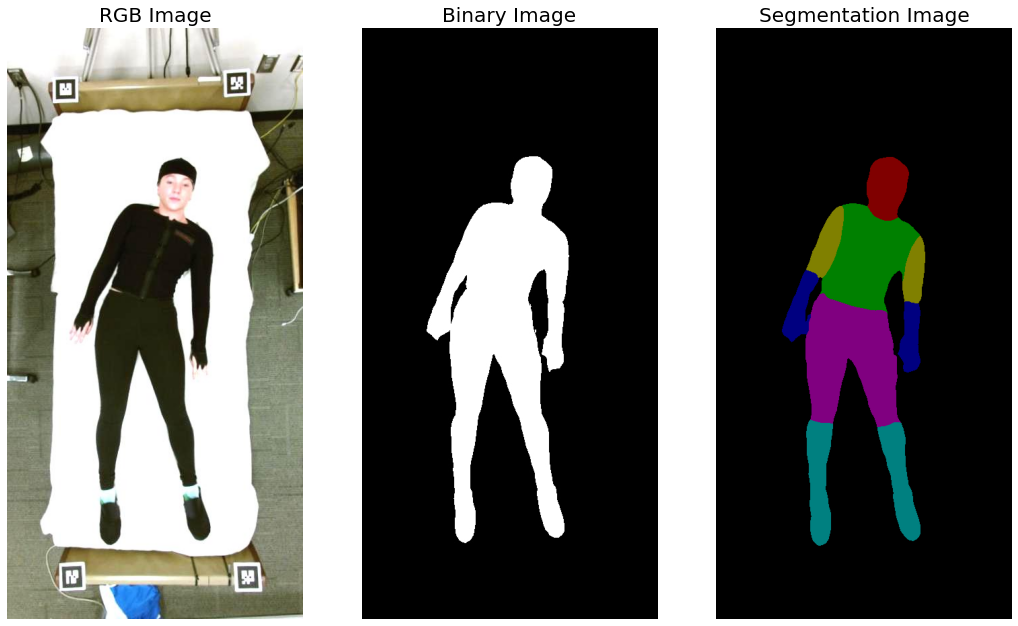

In [7]:
visualization("./img")